In [2]:
%reload_ext autoreload
%autoreload 2

import glob
from heapq import merge
import os
import re
import pickle
import scipy.io as sio

from ripple_heterogeneity.utils import (
    loading,
    add_new_deep_sup,
)

import nelpy as nel
import pandas as pd
import numpy as np
import warnings

# packages for main analsis
from fooof import FOOOF, FOOOFGroup
from fooof.analysis.periodic import get_band_peak, get_band_peak_group
from neurodsp import spectral
from neurodsp.plts.spectral import *
from neurodsp.plts.time_series import plot_time_series
from fooof.utils import trim_spectrum
from fooof.plts.spectra import plot_spectrum, plot_spectra, plot_spectrum_shading, plot_spectra_shading


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
basepath = r"Z:\Data\HMC2\day13"
# load session to get brain region for theta
brain_region = loading.load_brain_regions(basepath)
theta_chan = brain_region['CA1sr']['channels'][-1] - 1
theta_chan

106

In [8]:
def process_lfp(basepath,theta_chan,state_ep):
    # load xml for lfp import
    n_channels, fs, _, _ = loading.loadXML(basepath)

    # function to load lfp
    lfp, ts = loading.loadLFP(basepath, n_channels=n_channels,
                        channel=theta_chan,
                        frequency=fs)

    return nel.AnalogSignalArray(lfp, timestamps=ts,fs = fs)[state_ep]

def get_theta_epochs(basepath):
    # epoch lfp into REM and RUN states
    state_dict = loading.load_SleepState_states(basepath)

    wake = nel.EpochArray(state_dict['WAKEstate'])
    rem = nel.EpochArray(state_dict['REMstate'])
    theta = nel.EpochArray(state_dict['THETA'])

    return wake[theta], rem

In [9]:
wake_ep, rem_ep = get_theta_epochs(basepath)
lfp = process_lfp(basepath,theta_chan,rem_ep)

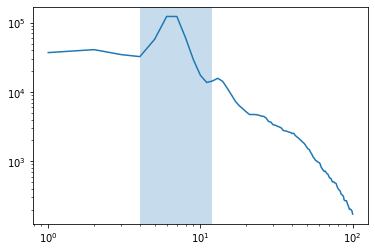

In [18]:
freqs, powers = spectral.compute_spectrum(lfp.data, 1250,
                                    method='welch',
                                    avg_type='mean')

# Trim spectrum to be only between 3 & 100 Hz (default)
freqs, powers = trim_spectrum(freqs, powers, [1, 100])
plt.plot(freqs,powers.T)
plt.axvspan(4,12,zorder=-10,alpha=.25)
plt.xscale("log")
plt.yscale("log")
plt.show()